In [149]:
import numpy as np
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font_scale=1.5, color_codes=True)

### EDA

Load Data into a pandas dataframe

In [82]:
recipies = pd.read_json("recipies.json")
recipies.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


This is a multilabel, unbalanced classification task

In [83]:
recipies['cuisine'].describe()

count       39774
unique         20
top       italian
freq         7838
Name: cuisine, dtype: object

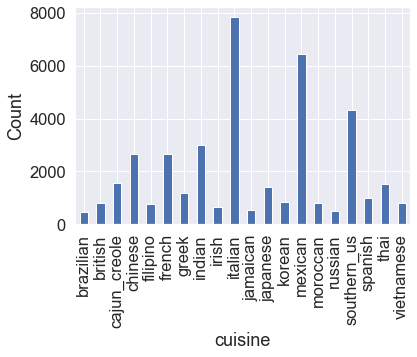

In [84]:
recipies['cuisine'].value_counts().sort_index().plot(kind='bar');
plt.ylabel("Count");
plt.xlabel("cuisine");

There are no missing values

In [85]:
recipies.isnull().mean()

id             0.0
cuisine        0.0
ingredients    0.0
dtype: float64

In [86]:
recipie_lengths = recipies['ingredients'].apply(len)

In [87]:
recipie_lengths.describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: ingredients, dtype: float64

In [88]:
recipies.insert(2, column='num_ingredients', value = recipie_lengths)

In [89]:
recipies.head()

,id,cuisine,num_ingredients,ingredients
0,10259,greek,9,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,11,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,12,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,4,"[water, vegetable oil, wheat, salt]"
4,13162,indian,20,"[black pepper, shallots, cornflour, cayenne pe..."


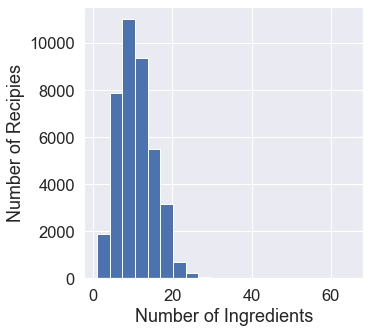

In [90]:
fig = plt.figure(figsize=(5,5))
plt.hist(recipies['num_ingredients'], bins=20)
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipies')
plt.show()

In [91]:
all_ingredients = [ingredient for ingredients in recipies['ingredients'] for ingredient in ingredients]
VOCAB = sorted(list(set(all_ingredients)))
print("%s unique ingredients total" % (len(VOCAB)))

6714 unique ingredients total


In [92]:
def tokenizer(text):
    return text.split('|')

In [93]:
## Join words to a single line as required by CountVectorizer
recipies['ingredients'] = recipies['ingredients'].apply(lambda x: '|'.join([word for word in x]))

In [105]:
cv = CountVectorizer(vocabulary=VOCAB, tokenizer=tokenizer)

In [121]:
X = recipies['ingredients']
y = recipies['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [142]:
pipeline = Pipeline([('vect', CountVectorizer(vocabulary=VOCAB, tokenizer=tokenizer)),
    ('clf', LogisticRegression(max_iter=1000))
])

In [143]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenizer a...
                                             '95% lean ground beef',
                                             'A Taste of Thai Rice Noodles',
                                             'Accent Seasoning',
                                             'Adobo All Purpose Seasoning', ...])),
                ('clf',
                

In [151]:
print(classification_report(pipeline.predict(X_test), y_test))

              precision    recall  f1-score   support

   brazilian       0.61      0.74      0.67        69
     british       0.43      0.57      0.49       120
cajun_creole       0.66      0.78      0.71       279
     chinese       0.83      0.77      0.80       548
    filipino       0.58      0.67      0.62       118
      french       0.65      0.61      0.63       588
       greek       0.67      0.74      0.71       227
      indian       0.89      0.87      0.88       617
       irish       0.42      0.60      0.50       106
     italian       0.88      0.81      0.84      1710
    jamaican       0.65      0.82      0.72        72
    japanese       0.73      0.81      0.76       255
      korean       0.72      0.84      0.78       141
     mexican       0.92      0.89      0.91      1380
    moroccan       0.74      0.87      0.80       141
     russian       0.46      0.57      0.51        72
 southern_us       0.78      0.69      0.73       957
     spanish       0.50    